## Lab 7 - Classification - Random Forest

In this notebook, we will see an example of using Random Forest to predict the trend in SPDR S&P 500 ETF Trust (SPY).

First, we need to get the data. We are using yahoo finance for that.

In [1]:
import yfinance as yf

df = yf.download('SPY').reset_index()

[*********************100%%**********************]  1 of 1 completed


We will be using the following classes of features:
- percentage change between the price and the Simple Moving Average indicator
- percentage change between the price and the rolling maximum/minimum value
- percentage change in the price from a number of days ago

Note that we care about percentage change and not absolute values! We don't wish to detect specific scenarios (e.g., "when the price reaches 200") but general scenarios ("the price increased by 1%").


In [2]:
# Deriving the features

# Distance from the moving averages
for m in [10,20,30,50,100]:
    df[f'feat_dist_from_ma_{m}'] = df['Close']/df['Close'].rolling(m).mean()-1
    
# Distance from n day max/min
for m in [3,5,10,15,20,30,50,100]:
    df[f'feat_dist_from_max_{m}'] = df['Close']/df['High'].rolling(m).max()-1
    df[f'feat_dist_from_min_{m}'] = df['Close']/df['Low'].rolling(m).min()-1

# Price distance
for m in [1,2,3,4,5,10,15,20,30,50,100]:
    df[f'feat_price_dist_{m}'] = df['Close']/df['Close'].shift(m)-1

Next, we define our target variable. In this example, we ask if we can predict if SPY will be above its 20-day Simple Moving Average in 5 days time.

In [3]:
# Target = if the price above the 20 MA in 5 days time
df['target_ma'] = df['Close'].rolling(20).mean()
df['price_above_ma'] = df['Close']>df['target_ma']
df['target'] = df['price_above_ma'].astype(int).shift(-5)

We clean rows with empty data. As we are asking to predict 5 days ahead, the next 5 days haven't yet happened, so there is no target to learn from.
_dropna()_ takes care of that by eliminating these rows.

We also define until when the training set lasts and proceed with defining training set (x_train, y_train) and test set (x_test, y_test).

In [5]:
df = df.dropna()

feat_cols = [col for col in df.columns if 'feat' in col]
train_until = '2022-01-01'

x_train = df[df['Date'] < train_until][feat_cols]
y_train = df[df['Date'] < train_until]['target']

x_test = df[df['Date'] >= train_until][feat_cols]
y_test = df[df['Date'] >= train_until]['target']

Now, we define the model. We keep the depth at 3 in an attempt to avoid overfitting. We would like to learn 'general rules' (assuming these exist) and not exact patterns.

_Random_state_ is set so that results can be replicated. The number 42 has, for a long time, been a favourite number as it is the meaning of life, the universe, and everything ([see also](https://en.wikipedia.org/wiki/42_(number)))

Do you know what 'accuracy' and 'precision' stand for below? One could make the argument that, in a financial setting, Precision is particulary important; we can act on a positive signal and we would like to be right as frequently as possible.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

clf = RandomForestClassifier(
    n_estimators = 100, 
    max_depth = 3,
    random_state = 42,
    class_weight = 'balanced',
)

clf.fit(x_train, y_train)

y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

# Calculate accuracy and precision for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)

# Calculate accuracy and precision for test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

print("Training accuracy: ", train_accuracy)
print("Training precision: ", train_precision)

print("Test accuracy: ", test_accuracy)
print("Test accuracy: ", test_accuracy)


Training accuracy:  0.7174669450243563
Training precision:  0.8099926162933793
Test accuracy:  0.7560521415270018
Test accuracy:  0.7560521415270018


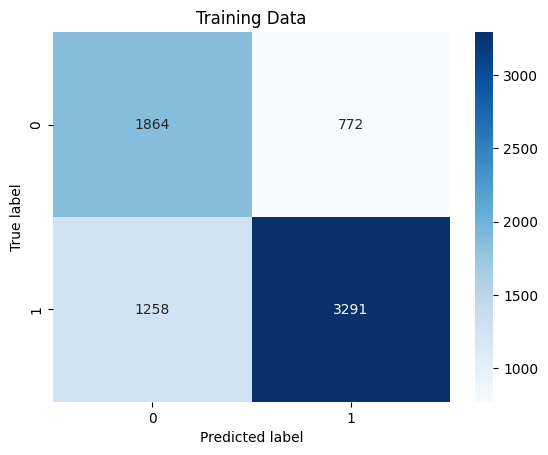

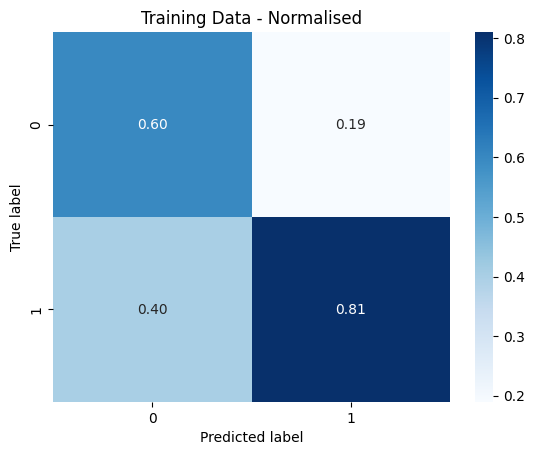

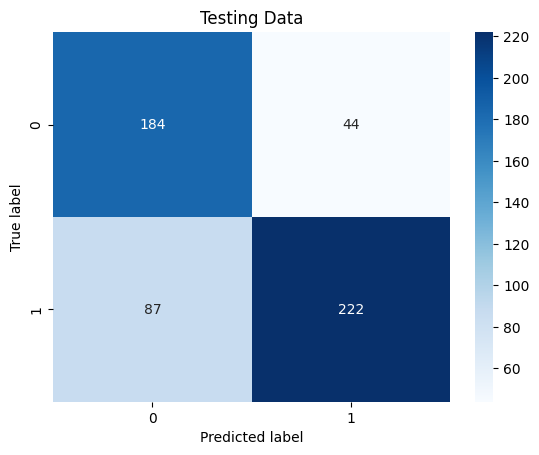

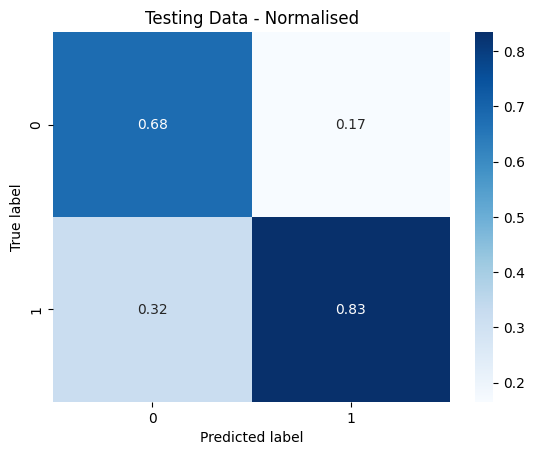

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title, normalize):
    
    if normalize:
        cm = confusion_matrix(y_true, y_pred, normalize = 'pred')
        sns.heatmap(cm, annot = True, fmt = '.2f', cmap = "Blues")
    else:
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot = True, fmt = 'd', cmap = "Blues")
    
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return

plot_confusion_matrix(y_train, y_train_pred, title = 'Training Data', normalize = False)
plot_confusion_matrix(y_train, y_train_pred, title = 'Training Data - Normalised', normalize = True)

plot_confusion_matrix(y_test, y_test_pred, title = 'Testing Data', normalize = False)
plot_confusion_matrix(y_test, y_test_pred, title = 'Testing Data - Normalised', normalize = True)


We might also care about which features are the most important. Fortunately, we can figure it out.

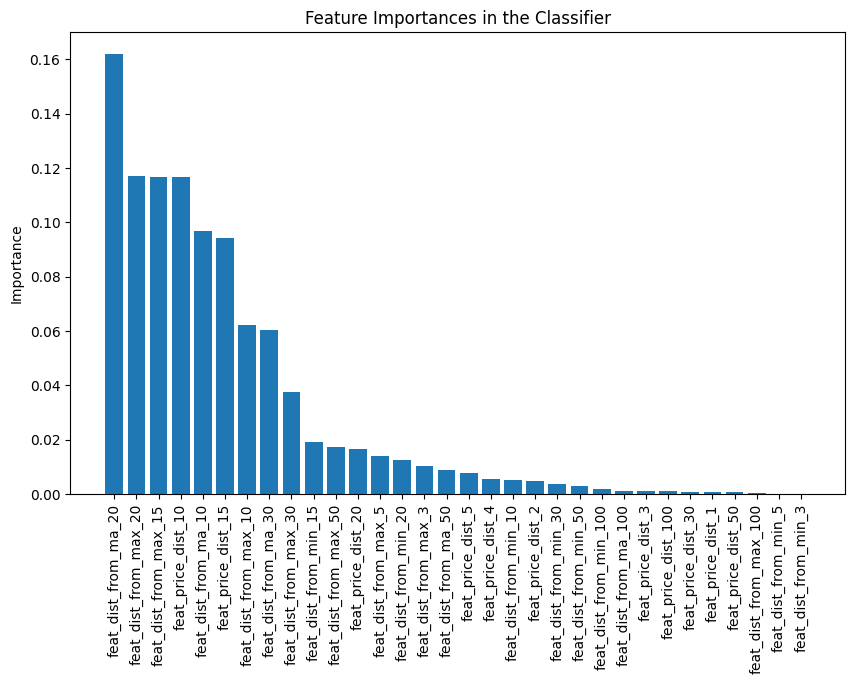

In [8]:
feature_importances = clf.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances in the Classifier")
plt.bar(range(x_train.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(x_train.shape[1]), x_train.columns[sorted_indices], rotation = 90)
plt.ylabel('Importance')
plt.show()
        

As a final step, let's visualise how we are doing.

In [10]:
import plotly.graph_objects as go

df_test = df[df['Date'] >= train_until].reset_index(drop=True)
df_test['pred_prob'] = clf.predict_proba(x_test)[:, 1]
df_test['pred'] = df_test['pred_prob'] >= 0.5

fig = go.Figure()

fig.add_trace(
    go.Candlestick(
        x = df_test['Date'],
        open = df_test['Open'],
        high = df_test['High'],
        low = df_test['Low'],
        close = df_test['Close'],
        showlegend = False,
    )
)

fig.add_trace(
    go.Line(x = df_test['Date'], y = df_test[f'target_ma'], name = f'Target SMA')
)

df_pattern = (
    df_test[df_test['pred']].groupby((~df_test['pred']).cumsum())
    ['Date'].agg(['first', 'last'])
)

for idx, row in df_pattern.iterrows():
    fig.add_vrect(
        x0 = row['first'],
        x1 = row['last'],
        line_width = 0,
        fillcolor = 'green',
        opacity = 0.2,
    )
    
fig.update_layout(
    xaxis_rangeslider_visible = False,
    xaxis_title = 'Date',
    yaxis_title = 'Price',
    title = 'Classified Results on SPY',
    width = 1000,
    height = 700,
)

fig.show()

c:\Users\sofia\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## Some Tasks to consider
- What would happen if you toyed with the maximum depth, or the number of estimators?
- What about other financial data, besides SPY?
- What about different targets? For example, we focussed on the 20 days Moving Average; would we see similar results if we considered, let's say, a 3 days Moving Average?